In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import holidays

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-ecommerce/processed_full.csv
/kaggle/input/online-retail-2009-2011/uk_dataset_full.csv


In [2]:
df = pd.read_csv("/kaggle/input/preprocessed-ecommerce/processed_full.csv")
df.shape

(739, 33)

In [3]:
series = df.copy()
series.head(5)

date  quantity  month  day_of_month  is_month_start  is_month_end  \
0  2009-12-01   26434.0     12             1               1             0   
1  2009-12-02   31938.0     12             2               0             0   
2  2009-12-03   50898.0     12             3               0             0   
3  2009-12-04   21405.0     12             4               0             0   
4  2009-12-05    5119.0     12             5               0             0   

   day_of_year  week_of_year  day_of_week  year  ...    lag_6    lag_7  \
0          335            49            2  2009  ...  26434.0  26434.0   
1          336            49            3  2009  ...  26434.0  26434.0   
2          337            49            4  2009  ...  26434.0  26434.0   
3          338            49            5  2009  ...  26434.0  26434.0   
4          339            49            6  2009  ...  26434.0  26434.0   

   rolling_mean_7  rolling_sum_7  rolling_std_7  rolling_mean_30  \
0    23710.571429       165974.0   14932.597372     17233.666667   
1    23710.571429       165974.0   14932.597372     17233.666667   
2    23710.571429       165974.0   14932.597372     17233.666667   
3    23710.571429       165974.0   14932.597372     17233.666667   
4    23710.571429       165974.0   14932.597372     17233.666667   

   rolling_sum_30  rolling_std_30  expanding_sum  quantity_winsorized  
0        517010.0    12220.541413        26434.0              26434.0  
1        517010.0    12220.541413        58372.0              31938.0  
2        517010.0    12220.541413       109270.0              50898.0  
3        517010.0    12220.541413       130675.0              21405.0  
4        517010.0    12220.541413       135794.0               5119.0  

[5 rows x 33 columns]

In [9]:
series["ds"] = series["date"]
series["unique_id"] = "daily_sales"
series["y"] = series["quantity_winsorized"]
series = series[["ds","unique_id","y"]]
series.head()

ds    unique_id        y
0  2009-12-01  daily_sales  26434.0
1  2009-12-02  daily_sales  31938.0
2  2009-12-03  daily_sales  50898.0
3  2009-12-04  daily_sales  21405.0
4  2009-12-05  daily_sales   5119.0

In [10]:
series.head()

ds    unique_id        y
0  2009-12-01  daily_sales  26434.0
1  2009-12-02  daily_sales  31938.0
2  2009-12-03  daily_sales  50898.0
3  2009-12-04  daily_sales  21405.0
4  2009-12-05  daily_sales   5119.0

In [11]:
series["ds"]= pd.to_datetime(series["ds"])

In [12]:
!pip install mlforecast scikit-learn xgboost lightgbm

In [13]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         739 non-null    datetime64[ns]
 1   unique_id  739 non-null    object        
 2   y          739 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 17.4+ KB


In [14]:
xa = series.copy()


In [ ]:
series = xa.copy()

In [15]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error


def create_date_features(data):
    data["month"] = data.index.month
    data["day_of_month"] = data.index.day
    data["is_month_start"] = data.index.is_month_start.astype(int)
    data["is_month_end"] = data.index.is_month_end.astype(int)
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_week"] = data.index.dayofweek + 1
    data["year"] = data.index.year
    data["is_weekend"] = data.index.weekday >= 5
    data['is_spring'] = data['month'].isin([3, 4, 5]).astype(int)
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)
    data['is_fall'] = data['month'].isin([9, 10, 11]).astype(int)
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)
    data['sin_day'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['cos_day'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    return data


# Assuming you have your series data loaded correctly and processed as before

# Step 2: Load and Preprocess the Data
# Create a sample DataFrame 'series' similar to your actual dataset
series.set_index('ds', inplace=True)
series = create_date_features(series)
series.reset_index(inplace=True)

# Ensure the correct data types for the columns
series['ds'] = pd.to_datetime(series['ds'])
series['unique_id'] = series['unique_id'].astype(str)
series['y'] = series['y'].astype(float)

# Step 3: Define Features and Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100)
}

# Specify the features to be used in the model
date_features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
                'day_of_year', 'week_of_year', 'day_of_week', 'year',
                'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
                'sin_day', 'cos_day']

# Step 4: Define the Forecasting Pipeline
forecast = MLForecast(
    models=models,
    freq='D',  # Daily frequency
    lags=[1, 2, 3],  # Using 1, 2, 3 days lagged features
   
)

# Step 5: Train the Models
forecast.fit(series, id_col='unique_id', time_col='ds', target_col='y')

# Step 6: Evaluate the Models
# We'll use the last 30 days as the test set for evaluation
train_df = series[['ds', 'unique_id', 'y']][:-30]  # Select only necessary columns
test_df = series[['ds', 'unique_id', 'y']][-30:]    # Select only necessary columns
forecast.fit(train_df, id_col='unique_id', time_col='ds', target_col='y')

# Generate predictions for the test set
predictions = forecast.predict(30)

# Calculate Mean Absolute Percentage Error (MAPE) for each model
mape_scores = {
    model_name: mean_absolute_percentage_error(test_df['y'], predictions[model_name])
    for model_name in models.keys()
}

# Step 7: Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Step 8: Make Predictions
# Retrain the best model on the entire dataset
forecast.models = {best_model_name: models[best_model_name]}
forecast.fit(series, id_col='unique_id', time_col='ds', target_col='y')

# Predict the next 30 days
future_predictions = forecast.predict(30)
# print(f"Predictions for the next 30 days using {best_model_name}:")
# print(future_predictions[best_model_name])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 18
[LightGBM] [Info] Start training from score 18064.084239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [7]:
series.head()

date  quantity  month  day_of_month  is_month_start  is_month_end  \
0  2009-12-01   26434.0     12             1               1             0   
1  2009-12-02   31938.0     12             2               0             0   
2  2009-12-03   50898.0     12             3               0             0   
3  2009-12-04   21405.0     12             4               0             0   
4  2009-12-05    5119.0     12             5               0             0   

   day_of_year  week_of_year  day_of_week  year  ...    lag_6    lag_7  \
0          335            49            2  2009  ...  26434.0  26434.0   
1          336            49            3  2009  ...  26434.0  26434.0   
2          337            49            4  2009  ...  26434.0  26434.0   
3          338            49            5  2009  ...  26434.0  26434.0   
4          339            49            6  2009  ...  26434.0  26434.0   

   rolling_mean_7  rolling_sum_7  rolling_std_7  rolling_mean_30  \
0    23710.571429       165974.0   14932.597372     17233.666667   
1    23710.571429       165974.0   14932.597372     17233.666667   
2    23710.571429       165974.0   14932.597372     17233.666667   
3    23710.571429       165974.0   14932.597372     17233.666667   
4    23710.571429       165974.0   14932.597372     17233.666667   

   rolling_sum_30  rolling_std_30  expanding_sum  quantity_winsorized  
0        517010.0    12220.541413        26434.0              26434.0  
1        517010.0    12220.541413        58372.0              31938.0  
2        517010.0    12220.541413       109270.0              50898.0  
3        517010.0    12220.541413       130675.0              21405.0  
4        517010.0    12220.541413       135794.0               5119.0  

[5 rows x 33 columns]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 18
[LightGBM] [Info] Start training from score 18064.084239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

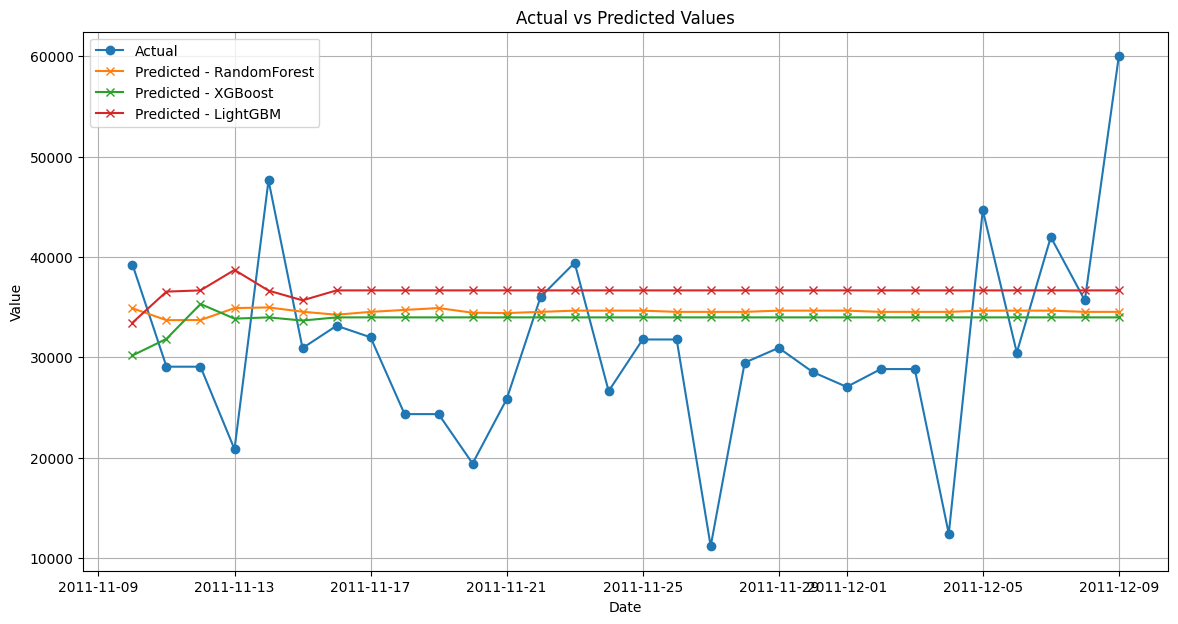

In [16]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Function to create date features
def create_date_features(data):
    data["month"] = data.index.month
    data["day_of_month"] = data.index.day
    data["is_month_start"] = data.index.is_month_start.astype(int)
    data["is_month_end"] = data.index.is_month_end.astype(int)
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_week"] = data.index.dayofweek + 1
    data["year"] = data.index.year
    data["is_weekend"] = (data.index.weekday >= 5).astype(int)
    data['is_spring'] = data['month'].isin([3, 4, 5]).astype(int)
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)
    data['is_fall'] = data['month'].isin([9, 10, 11]).astype(int)
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)
    data['sin_day'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['cos_day'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    return data

# Assuming you have your series data loaded correctly and processed as before

series.set_index('ds', inplace=True)
series = create_date_features(series)
series.reset_index(inplace=True)

# Ensure the correct data types for the columns
series['ds'] = pd.to_datetime(series['ds'])
series['unique_id'] = series['unique_id'].astype(str)
series['y'] = series['y'].astype(float)

# Define Features and Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100)
}

# Specify the features to be used in the model
date_features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
                 'day_of_year', 'week_of_year', 'day_of_week', 'year',
                 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
                 'sin_day', 'cos_day']

# Define the Forecasting Pipeline
forecast = MLForecast(
    models=models,
    freq='D',  # Daily frequency
    lags=[1, 2, 3],  # Using 1, 2, 3 days lagged features
  
)

# Train the Models
forecast.fit(series, id_col='unique_id', time_col='ds', target_col='y')

# Evaluate the Models
# We'll use the last 30 days as the test set for evaluation
train_df = series[:-30]
test_df = series[-30:]
forecast.fit(train_df, id_col='unique_id', time_col='ds', target_col='y')

# Generate predictions for the test set
predictions = forecast.predict(30)

# Calculate Mean Absolute Percentage Error (MAPE) for each model
mape_scores = {
    model_name: mean_absolute_percentage_error(test_df['y'], predictions[model_name])
    for model_name in models.keys()
}

# Print MAPE scores
for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
forecast.models = {best_model_name: models[best_model_name]}
forecast.fit(series, id_col='unique_id', time_col='ds', target_col='y')

# Predict the next 30 days
future_predictions = forecast.predict(30)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
for model_name in models.keys():
    plt.plot(test_df['ds'], predictions[model_name], label=f'Predicted - {model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 725, number of used features: 5
[LightGBM] [Info] Start training from score 18026.668966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

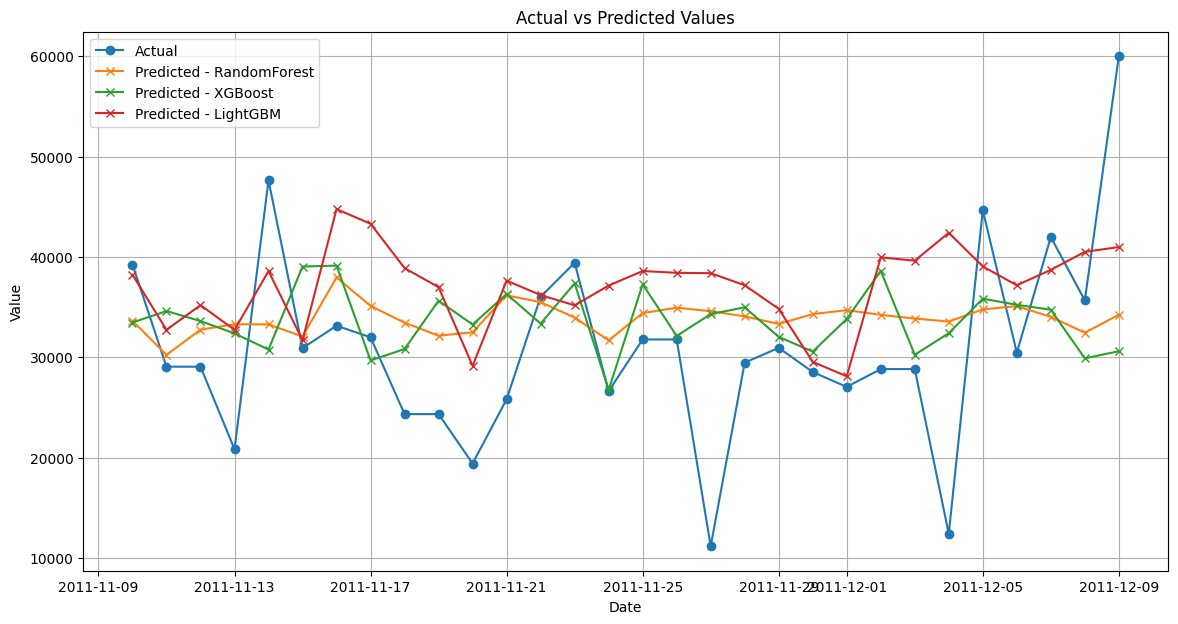

In [57]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Define Your Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=7, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, num_leaves=31, learning_rate=0.05)
}

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = series.index

# Specify the Forecasting Pipeline
forecast = MLForecast(
    models=models,
    freq='D',  # Daily frequency
    lags=[1, 2, 3, 7, 14]  # Lags to consider
)

# Train the Models
forecast.fit(series[['unique_id', 'y', 'ds']])

# Generate predictions for the test set (last 30 days)
train_df = series.iloc[:-30]
test_df = series.iloc[-30:]
forecast.fit(train_df[['unique_id', 'y', 'ds']])

# Predict the next 30 days
predictions = forecast.predict(30)

# Calculate Mean Absolute Percentage Error (MAPE) for each model
mape_scores = {
    model_name: mean_absolute_percentage_error(test_df['y'], predictions[model_name])
    for model_name in models.keys()
}

# Print MAPE scores
for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
forecast.models = {best_model_name: models[best_model_name]}
forecast.fit(series[['unique_id', 'y', 'ds']])

# Predict the next 30 days with the best model
best_model_predictions = forecast.predict(30)

# Plot actual vs predicted values for model comparison
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
for model_name in models.keys():
    plt.plot(test_df['ds'], predictions[model_name], label=f'Predicted - {model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 725, number of used features: 5
[LightGBM] [Info] Start training from score 18026.668966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

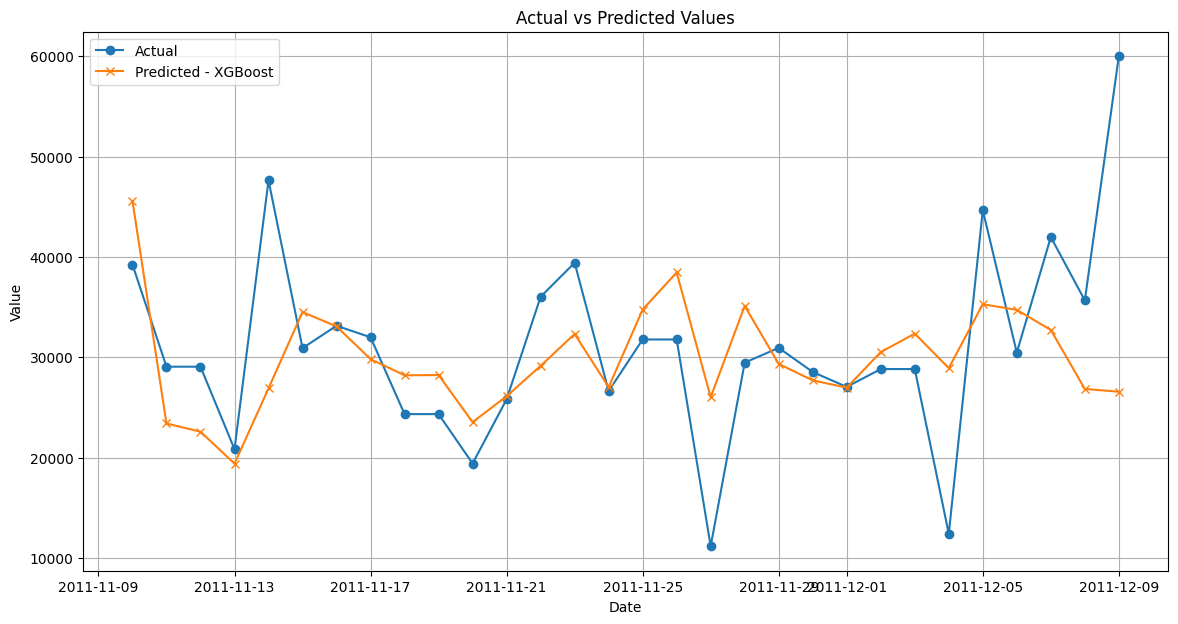

In [70]:
 import pandas as pd
import numpy as np
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

# Define Your Models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

# Hyperparameter Tuning for RandomForestRegressor (example)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = series.index

# Specify the Forecasting Pipeline
forecast = MLForecast(
    models=models,
    freq='D',  # Daily frequency
    lags=[1, 2, 3, 7, 14]  # Lags to consider
)

# Train the Models
forecast.fit(series[['unique_id', 'y', 'ds']])

# Generate predictions for the test set (last 30 days)
train_df = series.iloc[:-30]
test_df = series.iloc[-30:]

# Predict the next 30 days with the best model
predictions = forecast.predict(30)

# Calculate Mean Absolute Percentage Error (MAPE) for each model
mape_scores = {
    model_name: mean_absolute_percentage_error(test_df['y'], predictions[model_name])
    for model_name in models.keys()
}

# Print MAPE scores
for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
forecast.models = {best_model_name: models[best_model_name]}
forecast.fit(series[['unique_id', 'y', 'ds']])

# Predict the next 30 days with the best model
best_model_predictions = forecast.predict(30)

# Plot actual vs predicted values for model comparison
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], best_model_predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


Tuning and Training RandomForest
Tuning and Training XGBoost
Tuning and Training LightGBM
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=Fa

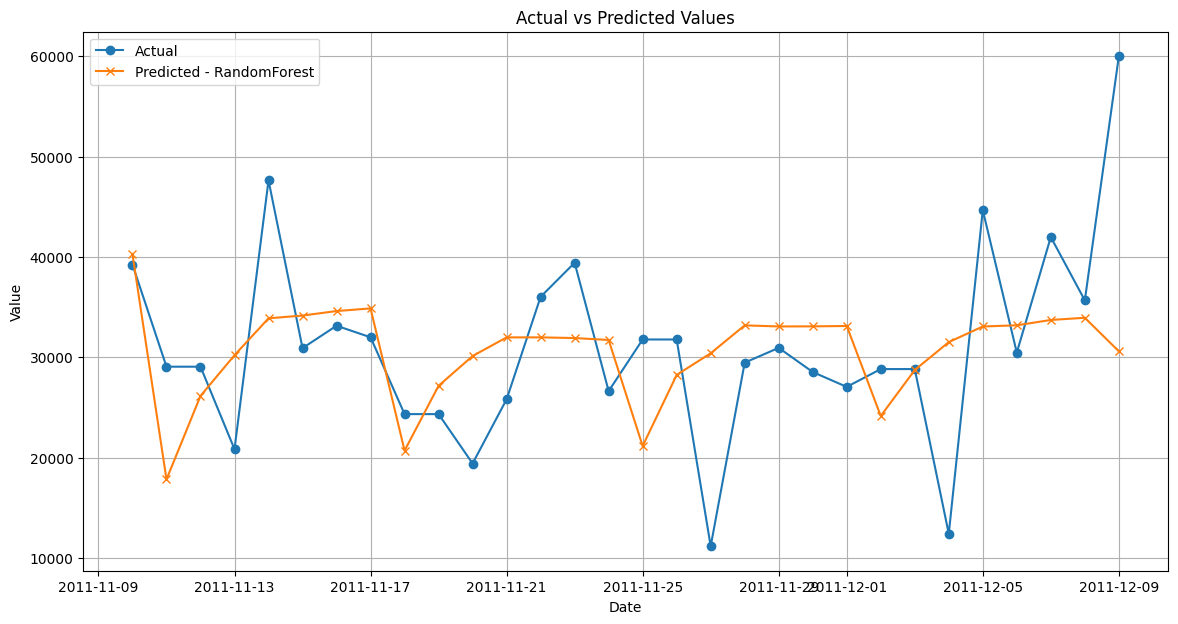

In [73]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder


# Define Your Models (more concisely)
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

# Comprehensive Hyperparameter Grids
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 63, 127],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = series.index

# Label encode categorical variables (if any)
le = LabelEncoder()
for col in series.columns:
    if series[col].dtype == 'object':
        series[col] = le.fit_transform(series[col])

# Specify the Forecasting Pipeline
forecast = MLForecast(models=models, freq='D', lags=[1, 2, 3, 7, 14])


# Train the Models with Hyperparameter Tuning
for model_name, model in models.items():
    print(f"Tuning and Training {model_name}")
    random_search = RandomizedSearchCV(model, param_distributions=param_grids[model_name], n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
    forecast.models[model_name] = random_search
forecast.fit(series[['unique_id', 'y', 'ds']])

# Generate predictions on the test set and evaluate
test_df = series.iloc[-30:]
predictions = forecast.predict(30)

# Calculate and print MAPE scores
mape_scores = {
    model_name: mean_absolute_percentage_error(test_df['y'], predictions[model_name])
    for model_name in models.keys()
}
for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
forecast.models = {best_model_name: models[best_model_name]}  # Keep only the best model
forecast.fit(series[['unique_id', 'y', 'ds']])

# Predict the next 30 days with the best model
best_model_predictions = forecast.predict(30)

# Plot actual vs predicted values for model comparison
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


Tuning and Training RandomForest
Tuning and Training XGBoost
Tuning and Training LightGBM
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, max_de

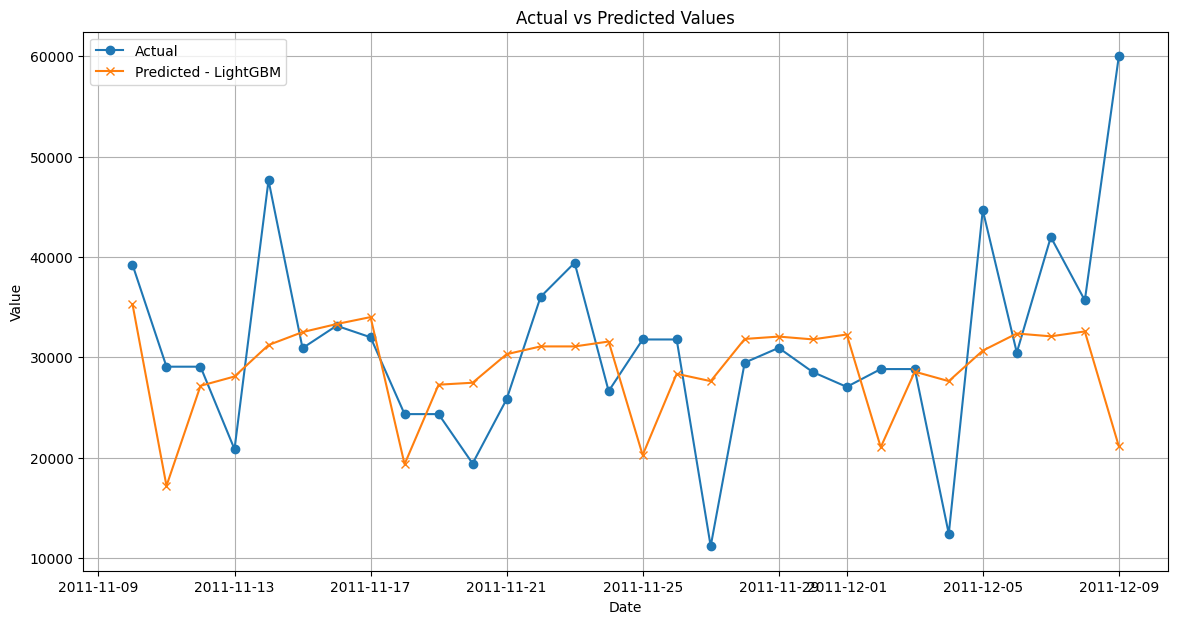

In [76]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder


# Define Your Models 
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

# Comprehensive Hyperparameter Grids
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300, 500],
        'num_leaves': [31, 63, 127],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0.0, 0.1, 1.0],
        'reg_lambda': [0.0, 0.1, 1.0]
    }
}


# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = series.index

# Label encode categorical variables (if any)
le = LabelEncoder()
for col in series.columns:
    if series[col].dtype == 'object':
        series[col] = le.fit_transform(series[col])

# Specify the Forecasting Pipeline
forecast = MLForecast(models=models, freq='D', lags=[1, 2, 3, 7, 14])

# Train the Models with Hyperparameter Tuning (using more iterations)
for model_name, model in models.items():
    print(f"Tuning and Training {model_name}")
    random_search = RandomizedSearchCV(model, param_distributions=param_grids[model_name], n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)
    forecast.models[model_name] = random_search
forecast.fit(series[['unique_id', 'y', 'ds']])

# Generate predictions on the test set and evaluate
test_df = series.iloc[-30:]
predictions = forecast.predict(30)

# Calculate and print MAPE scores
mape_scores = {
    model_name: mean_absolute_percentage_error(test_df['y'], predictions[model_name])
    for model_name in models.keys()
}
for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
forecast.models = {best_model_name: models[best_model_name]}  # Keep only the best model
forecast.fit(series[['unique_id', 'y', 'ds']])

# Predict the next 30 days with the best model
best_model_predictions = forecast.predict(30)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Plot actual vs predicted values for model comparison
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


AutoETS MAPE: 2.141122211434679
AutoARIMA MAPE: 1.4380910643419844
Naive MAPE: 5.197987491275371
The best model is AutoARIMA with a MAPE of 1.4380910643419844


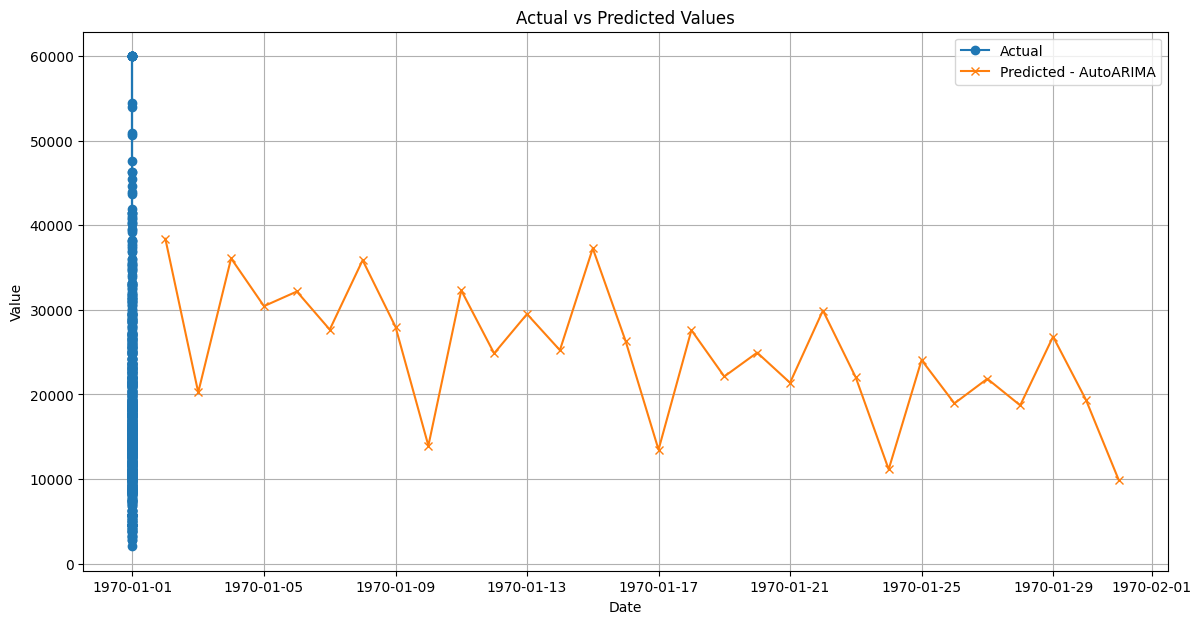

In [15]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = pd.to_datetime(series.index) 

# Initialize StatsForecast with the desired models
fcst = StatsForecast(
    df=series,
    models=[
        AutoETS(model='ZMZ', season_length=4),
        AutoARIMA(season_length=7, d=0),
        Naive()
    ],
    freq='D',
    n_jobs=-1
)

# Train Models
fcst.fit()

# Generate forecasts
forecasts = fcst.forecast(h=30, fitted=True)

# Calculate and print MAPE scores
last_date = series['ds'].max()
start_date_for_test = last_date - timedelta(days=29)  # Last 30 days (inclusive of the last date)
test_df = series[series['ds'] >= start_date_for_test]

mape_scores = {}
for model in fcst.models:
    model_name = type(model).__name__
    try:
        y_pred = forecasts[model_name].values[:30]
        y_true = test_df['y'].values[:30]  # Align lengths by taking the first 30 values
        mape_scores[model_name] = mean_absolute_percentage_error(y_true, y_pred)
    except KeyError:
        print(f"Forecast for model {model_name} not found in forecasts DataFrame.")

for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
fcst_best_model = StatsForecast(
    df=series,
    models=[model for model in fcst.models if type(model).__name__ == best_model_name],
    freq='D'
)
fcst_best_model.fit()

# Predict the next 30 days with the best model
final_forecasts = fcst_best_model.forecast(h=30)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Correctly filter the test DataFrame
test_df = series[series['ds'] >= start_date_for_test]

plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot forecasts
plt.plot(
    pd.date_range(test_df['ds'].max() + pd.to_timedelta('1 days'), periods=30, freq='D'),
    final_forecasts[best_model_name].values,
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


Best AutoETS Params: {'model': 'MAM', 'season_length': 4} with MAPE: 2.0554840169453166
Best AutoARIMA Params: {'season_length': 4, 'd': 0, 'max_p': 2, 'max_q': 2} with MAPE: 0.9398938183000293
AutoETS MAPE: 2.0554840169453166
AutoARIMA MAPE: 0.9398938183000293
Naive MAPE: 5.197987491275371
The best model is AutoARIMA with a MAPE of 0.9398938183000293


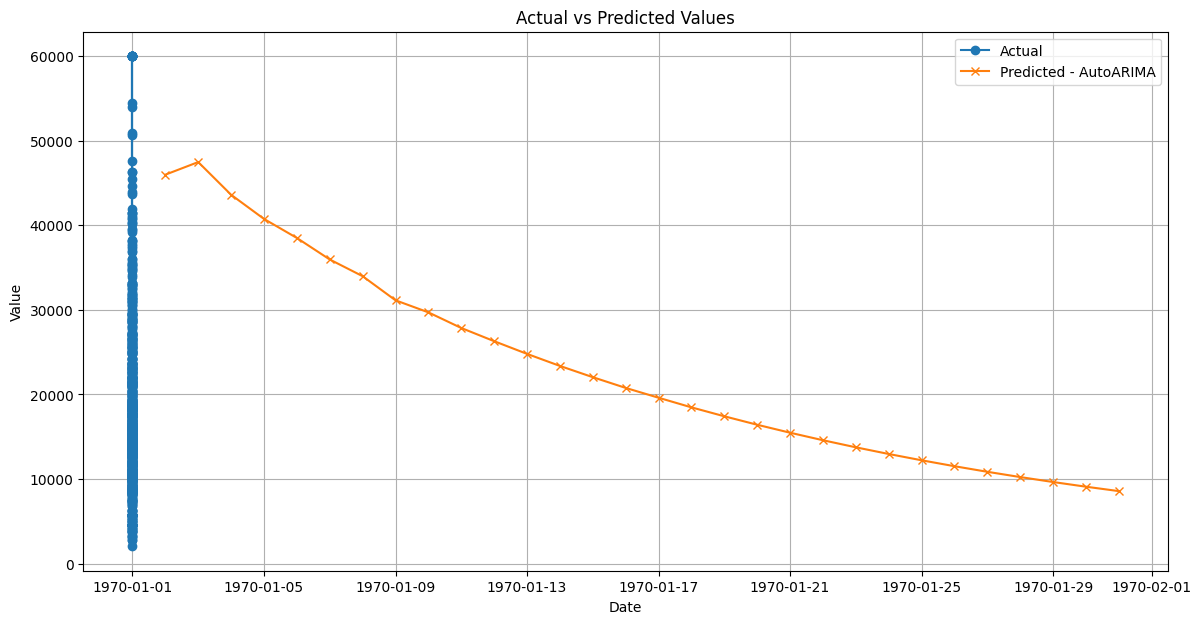

In [16]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from datetime import timedelta

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = pd.to_datetime(series.index)

# Define hyperparameter grids
autoets_param_grid = {
    'model': ['AAA', 'MAM', 'ZZZ'],
    'season_length': [4, 7, 12],
}

autoarima_param_grid = {
    'season_length': [4, 7, 12],
    'd': [0, 1, 2],
    'max_p': [2, 5, 10],
    'max_q': [2, 5, 10],
}

# Perform RandomizedSearchCV for AutoETS
def tune_autoets(series, param_grid):
    best_params = {}
    best_score = float('inf')

    for model in param_grid['model']:
        for season_length in param_grid['season_length']:
            ets_model = AutoETS(model=model, season_length=season_length)
            fcst = StatsForecast(
                df=series,
                models=[ets_model],
                freq='D',
                n_jobs=-1
            )
            fcst.fit()
            forecasts = fcst.forecast(h=30, fitted=True)
            
            last_date = series['ds'].max()
            start_date_for_test = last_date - timedelta(days=29)
            test_df = series[series['ds'] >= start_date_for_test]
            
            y_pred = forecasts['AutoETS'].values[:30]
            y_true = test_df['y'].values[:30]

            mape_score = mean_absolute_percentage_error(y_true, y_pred)
            if mape_score < best_score:
                best_score = mape_score
                best_params = {'model': model, 'season_length': season_length}
    
    return best_params, best_score

# Perform RandomizedSearchCV for AutoARIMA
def tune_autoarima(series, param_grid):
    best_params = {}
    best_score = float('inf')

    for season_length in param_grid['season_length']:
        for d in param_grid['d']:
            for max_p in param_grid['max_p']:
                for max_q in param_grid['max_q']:
                    arima_model = AutoARIMA(season_length=season_length, d=d, max_p=max_p, max_q=max_q)
                    fcst = StatsForecast(
                        df=series,
                        models=[arima_model],
                        freq='D',
                        n_jobs=-1
                    )
                    fcst.fit()
                    forecasts = fcst.forecast(h=30, fitted=True)
                    
                    last_date = series['ds'].max()
                    start_date_for_test = last_date - timedelta(days=29)
                    test_df = series[series['ds'] >= start_date_for_test]
                    
                    y_pred = forecasts['AutoARIMA'].values[:30]
                    y_true = test_df['y'].values[:30]

                    mape_score = mean_absolute_percentage_error(y_true, y_pred)
                    if mape_score < best_score:
                        best_score = mape_score
                        best_params = {'season_length': season_length, 'd': d, 'max_p': max_p, 'max_q': max_q}
    
    return best_params, best_score

# Tune AutoETS and AutoARIMA
best_autoets_params, best_autoets_score = tune_autoets(series, autoets_param_grid)
best_autoarima_params, best_autoarima_score = tune_autoarima(series, autoarima_param_grid)

print(f"Best AutoETS Params: {best_autoets_params} with MAPE: {best_autoets_score}")
print(f"Best AutoARIMA Params: {best_autoarima_params} with MAPE: {best_autoarima_score}")

# Initialize StatsForecast with the best models
best_ets_model = AutoETS(**best_autoets_params)
best_arima_model = AutoARIMA(**best_autoarima_params)

fcst = StatsForecast(
    df=series,
    models=[
        best_ets_model,
        best_arima_model,
        Naive()
    ],
    freq='D',
    n_jobs=-1
)

# Train Models
fcst.fit()

# Generate forecasts
forecasts = fcst.forecast(h=30, fitted=True)

# Calculate and print MAPE scores
last_date = series['ds'].max()
start_date_for_test = last_date - timedelta(days=29)  # Last 30 days (inclusive of the last date)
test_df = series[series['ds'] >= start_date_for_test]

mape_scores = {}
for model in fcst.models:
    model_name = type(model).__name__
    try:
        y_pred = forecasts[model_name].values[:30]
        y_true = test_df['y'].values[:30]  # Align lengths by taking the first 30 values
        mape_scores[model_name] = mean_absolute_percentage_error(y_true, y_pred)
    except KeyError:
        print(f"Forecast for model {model_name} not found in forecasts DataFrame.")

for model_name, mape_score in mape_scores.items():
    print(f"{model_name} MAPE: {mape_score}")

# Select the Best Model
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"The best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]}")

# Retrain the best model on the entire dataset
fcst_best_model = StatsForecast(
    df=series,
    models=[model for model in fcst.models if type(model).__name__ == best_model_name],
    freq='D'
)
fcst_best_model.fit()

# Predict the next 30 days with the best model
final_forecasts = fcst_best_model.forecast(h=30)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Correctly filter the test DataFrame
test_df = series[series['ds'] >= start_date_for_test]

plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot forecasts
plt.plot(
    pd.date_range(test_df['ds'].max() + pd.to_timedelta('1 days'), periods=30, freq='D'),
    final_forecasts[best_model_name].values,
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TFT, LSTM
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = pd.to_datetime(series.index)

# Split the data into training and test sets
train_df = series.iloc[:-30]
test_df = series.iloc[-30:]

# Define the models and their respective parameters
nhits_params = {
    'h': 30,
    'input_size': 1,  # Adjust based on your input features
}

nbeats_params = {
    'h': 30,
    'input_size': 1,  # Adjust based on your input features
}

tft_params = {
    'h': 30,
    'input_size': 1,  # Adjust based on your input features
}

lstm_params = {
    'h': 30,
    'input_size': 1,  # Adjust based on your input features
}

# Initialize the models without passing unsupported parameters
nhits_model = NHITS(**nhits_params)
nbeats_model = NBEATS(**nbeats_params)
tft_model = TFT(**tft_params)
lstm_model = LSTM(**lstm_params)

# Train each model on the training data
models = [nhits_model, nbeats_model, tft_model, lstm_model]
for model in models:
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(train_df)

# Initialize the best model based on evaluation metric (MAPE)
best_model_name = 'NHITS'  # Replace with the model with the lowest MAPE
best_params = nhits_params  # Replace with the best parameters found
best_model = NHITS(**nhits_params)

# Train the best model on the entire dataset
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(series)

# Predict the next 30 days with the best model
final_forecasts = nf_best_model.predict(h=30)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Plot the test data
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot the forecasts
plt.plot(
    pd.date_range(test_df['ds'].max() + pd.to_timedelta('1 days'), periods=30, freq='D'),
    final_forecasts['yhat'],
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TFT, LSTM
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Assuming 'series' is your DataFrame with 'ds' as the datetime column
series["ds"] = pd.to_datetime(series.index)
series = series.rename(columns={'ds': 'ds', 'value': 'y'})  # Rename value column to 'y' if necessary
series.reset_index(drop=True, inplace=True)  # Ensure the index is reset

# Split the data into training and test sets
train_df = series.iloc[:-30]
test_df = series.iloc[-30:]

# Define the models and their respective parameters
nhits_params = {
    'h': 30,
    'input_size': 30  # Example input size, adjust as needed
}

nbeats_params = {
    'h': 30,
    'input_size': 30  # Example input size, adjust as needed
}

tft_params = {
    'h': 30,
    'input_size': 30  # Example input size, adjust as needed
}

lstm_params = {
    'h': 30,
    'input_size': 30  # Example input size, adjust as needed
}

# Initialize the models
nhits_model = NHITS(**nhits_params)
nbeats_model = NBEATS(**nbeats_params)
tft_model = TFT(**tft_params)
lstm_model = LSTM(**lstm_params)

# Train each model on the training data and evaluate on test data
models = [nhits_model, nbeats_model, tft_model, lstm_model]
model_names = ['LSTM']
mape_scores = []

for model, name in zip(models, model_names):
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(train_df)
    forecasts = nf.predict(h=30)
    mape = mean_absolute_percentage_error(test_df['y'], forecasts['yhat'])
    mape_scores.append((name, mape))

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = None

if best_model_name == 'NHITS':
    best_model = NHITS(**nhits_params)
elif best_model_name == 'NBEATS':
    best_model = NBEATS(**nbeats_params)
elif best_model_name == 'TFT':
    best_model = TFT(**tft_params)
elif best_model_name == 'LSTM':
    best_model = LSTM(**lstm_params)

# Train the best model on the entire dataset
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(series)

# Predict the next 30 days with the best model
final_forecasts = nf_best_model.predict(h30)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Plot the test data
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot the forecasts
plt.plot(
    pd.date_range(test_df['ds'].max() + pd.to_timedelta('1 days'), periods=30, freq='D'),
    final_forecasts['yhat'],
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best model is {best_model_name} with a MAPE of {best_mape}")


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
data = series[["ds","unique_id","y"]]

data.head()

ds    unique_id        y
0 2009-12-01  daily_sales  26434.0
1 2009-12-02  daily_sales  31938.0
2 2009-12-03  daily_sales  50898.0
3 2009-12-04  daily_sales  21405.0
4 2009-12-05  daily_sales   5119.0

In [23]:
data.index = data["ds"]
data.head()
                  

ds    unique_id        y
ds                                         
2009-12-01 2009-12-01  daily_sales  26434.0
2009-12-02 2009-12-02  daily_sales  31938.0
2009-12-03 2009-12-03  daily_sales  50898.0
2009-12-04 2009-12-04  daily_sales  21405.0
2009-12-05 2009-12-05  daily_sales   5119.0

In [25]:
!pip install statsforecast s3fs datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.9.1
    Uninstalling aiohttp-3.9.1:
      Successfully uninstalled aiohttp-3.9.1


In [27]:
xv = data.copy()